https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/

https://machinelearningmastery.com/demystifying-ensemble-methods-boosting-bagging-and-stacking-explained/

https://scikit-learn.org/1.5/modules/ensemble.html

# Import Libraries

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load data Training and Testing Data

In [2]:
X_train = np.load('../../Data/Train Test Dataset - Feature 22/X_train.npy')
X_test = np.load('../../Data/Train Test Dataset - Feature 22/X_test.npy')
y_train = np.load('../../Data/Train Test Dataset - Feature 22/y_train.npy')
y_test = np.load('../../Data/Train Test Dataset - Feature 22/y_test.npy')

# Loading individual models

In [3]:
ann_model = load_model('../../H5 Files/Feature 22/ANN_Architecture_22_Features.h5')
lstm_model = load_model('../../H5 Files/Feature 22/LSTM_Architecture_22_Features.h5')
gru_model = load_model('../../H5 Files/Feature 22/GRU_Architecture_22_Features.h5')

### Get predictions from base models on training data

In [4]:
# Get predictions from base models on training data
ann_pred = ann_model.predict(X_train)
lstm_pred = lstm_model.predict(X_train)
gru_pred = gru_model.predict(X_train)

19412/19412 [==============================] - 88s 4ms/step


In [5]:
# Stack predictions horizontally for meta-model training data
X_train_stacked = np.hstack((ann_pred, lstm_pred, gru_pred))

In [6]:
X_train_stacked.shape

(621158, 3)

### Get predictions from base models on test data

In [7]:
# Get predictions from base models on test data
ann_pred_test = ann_model.predict(X_test)
lstm_pred_test = lstm_model.predict(X_test)
gru_pred_test = gru_model.predict(X_test)

4853/4853 [==============================] - 22s 4ms/step


In [8]:
# Stack predictions horizontally for meta-model test data
X_test_stacked = np.hstack((ann_pred_test, lstm_pred_test, gru_pred_test))

In [9]:
X_test_stacked.shape

(155290, 3)

# Bagging Ensemble Model

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [11]:
base_model = RandomForestClassifier(n_estimators=50, random_state=42)
bagging_model = BaggingClassifier(base_estimator=base_model, n_estimators=10, random_state=42)

In [12]:
# Train the Bagging model
start_time = time()
bagging_model.fit(X_train_stacked, y_train)
end_time = time()

training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

C:\Users\nafem\anaconda3\envs\gpu\lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Training time: 580.23 seconds


In [13]:
# Test the model
start_time_test = time()
ensemble_pred_test = bagging_model.predict(X_test_stacked)
end_time_test = time()

test_time = end_time_test - start_time_test
print(f"Test time: {test_time:.2f} seconds")

Test time: 12.51 seconds


# Model Evaluation

## Importing Libraries - Evaluation

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## Classification Report

In [15]:
ensemble_pred_test = (ensemble_pred_test > 0.5).astype(int)

classification_report = classification_report(y_test, ensemble_pred_test)
print(classification_report)

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     77676
           1       0.90      0.89      0.90     77614

    accuracy                           0.90    155290
   macro avg       0.90      0.90      0.90    155290
weighted avg       0.90      0.90      0.90    155290



## Confusion Matrix

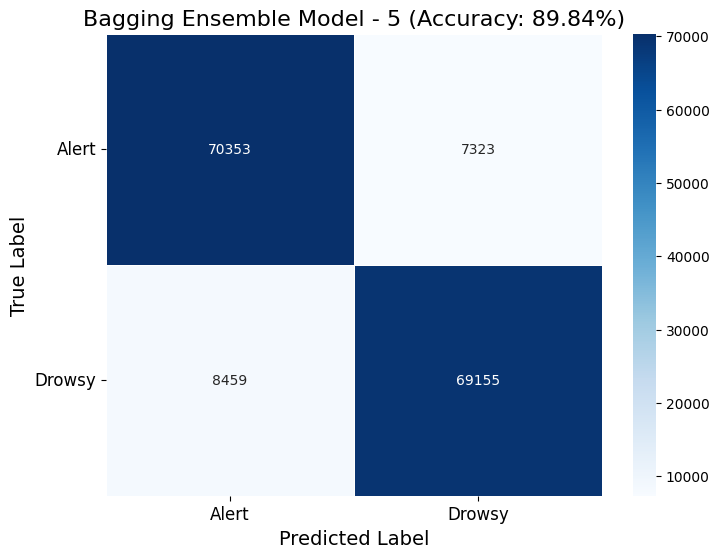

In [16]:
class_labels = ["Alert", "Drowsy"]

conf_matrix = confusion_matrix(y_test, ensemble_pred_test)
accuracy = accuracy_score(y_test, ensemble_pred_test) * 100

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True, xticklabels=class_labels, yticklabels=class_labels, linewidths=.5)

plt.title(f'Bagging Ensemble Model - 5 (Accuracy: {accuracy:.2f}%)', fontsize=16)

plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

plt.xticks(rotation=0, fontsize=12)  
plt.yticks(rotation=0, fontsize=12)  

plt.show()

## Evaluation Metrics

In [17]:
accuracy = accuracy_score(y_test, ensemble_pred_test)
precision = precision_score(y_test, ensemble_pred_test)
recall = recall_score(y_test, ensemble_pred_test)
f1 = f1_score(y_test, ensemble_pred_test)
auc_roc = roc_auc_score(y_test, ensemble_pred_test)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC-ROC:", auc_roc)

Accuracy: 0.8983707901345869
Precision: 0.9042469729856952
Recall: 0.8910119308372201
F1-score: 0.8975806660955793
AUC-ROC: 0.8983678532604145


## Receiver Operating Characteristic (ROC) Curve

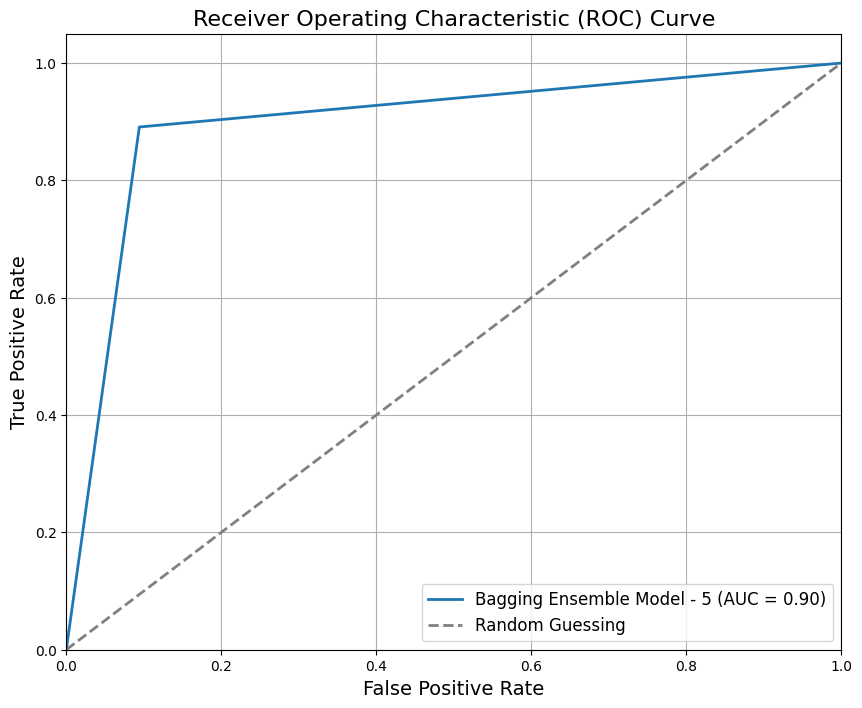

In [18]:
roc_data = {}

fpr, tpr, thresholds = roc_curve(y_test, ensemble_pred_test)
roc_auc = auc(fpr, tpr)
roc_data['Bagging Ensemble Model - 5'] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

# Plotting ROC Curves 
plt.figure(figsize=(10, 8))
for name, data in roc_data.items():
    plt.plot(data['fpr'], data['tpr'], lw=2, label=f'{name} (AUC = {data["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True)
plt.show()